In [1]:
from keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 8us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [6]:
print(test_targets)

[ 7.2 18.8 19.  27.  22.2 24.5 31.2 22.9 20.5 23.2 18.6 14.5 17.8 50.
 20.8 24.3 24.2 19.8 19.1 22.7 12.  10.2 20.  18.5 20.9 23.  27.5 30.1
  9.5 22.  21.2 14.1 33.1 23.4 20.1  7.4 15.4 23.8 20.1 24.5 33.  28.4
 14.1 46.7 32.5 29.6 28.4 19.8 20.2 25.  35.4 20.3  9.7 14.5 34.9 26.6
  7.2 50.  32.4 21.6 29.8 13.1 27.5 21.2 23.1 21.9 13.  23.2  8.1  5.6
 21.7 29.6 19.6  7.  26.4 18.9 20.9 28.1 35.4 10.2 24.3 43.1 17.6 15.4
 16.2 27.1 21.4 21.5 22.4 25.  16.6 18.6 22.  42.8 35.1 21.5 36.  21.9
 24.1 50.  26.7 25. ]


In [7]:
# Нормализация данных (нельзя использовать тестовые данные в расчетах)
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [11]:
# Определение модели
from keras import models, layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [12]:
# Кросс-валидация по K-фолдам
import numpy as np

k = 4
num_val_samples = len(train_data) // k  # количество объектов в валидационном наборе
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], 
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [15]:
np.mean(all_scores)

2.555386897065852

In [16]:
# Посмотрим на mae по эпохам
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], 
         train_data[(i + 1) * num_val_samples:]],
         axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], 
         train_targets[(i + 1) * num_val_samples:]],
         axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data=(val_data, val_targets), 
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [17]:
# История средних оценок кросс-валидации
avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

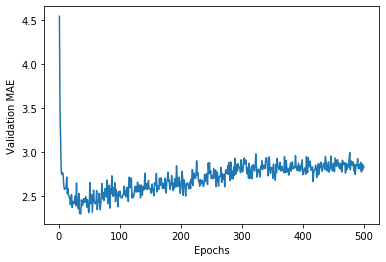

In [20]:
# График
import matplotlib.pyplot as plt

plt.plot(range(1, len(avg_mae_history) + 1), avg_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

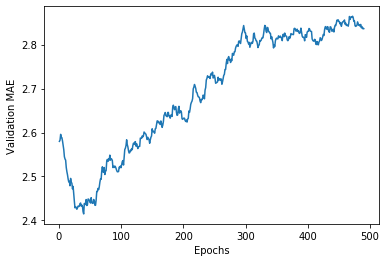

In [21]:
# Уберем первые 10 точек и сгладим кривую экспоненциальным скользящим средним
def smooth_curve(points, factor=.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smoothed_mae_history = smooth_curve(avg_mae_history[10:])

plt.plot(range(1, len(smoothed_mae_history) + 1), smoothed_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [22]:
# Эпоха с минимальным MAE на сглаженных данных 
np.argmin(smoothed_mae_history)

39

In [27]:
# Число эпох с минимальным MAE на исходных данных
np.argmin(avg_mae_history)

35

In [35]:
model = build_model()
model.fit(train_data, train_targets, 
          epochs=np.argmin(avg_mae_history),
          batch_size=1, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 1ms/step


In [36]:
# Окончательный результат
test_mae_score

2.5393002173479866